In [1]:
import numpy as np
import torch
import os
from pathlib import Path
import glob
import matplotlib.pyplot as plt
from torch.distributions import Categorical

from tangram import Tangram
from mcts2tree import MCTS2Tree
%matplotlib inline

In [4]:
torch.set_default_dtype(torch.float64)

network_seed=210
environment_seed=543
render=False
gpu=False
gamma=0.9

n_grid = 20
n_blocks = 4
n_possible_blocks = 6
chunk_type = 7
n_blocks_H = 1
n_distinct_samples = 690
n_samples = 690
n_simuls = 10 #25
n_evals = 100

serialization_paths = []

for n_blocks_H in [0,1]:
    serialization_paths.append('./models/mcts2/hierarchical_blocks_{}_n_samples_{}_unbiased_dataset_network_seed_{}'.format(n_blocks_H, n_samples, network_seed))

"""
serialization_path = './models/mcts2/hierarchical_blocks_{}'.format(n_blocks_H)
print('serialization_path: ',serialization_path)
# create folder 
Path(serialization_path).mkdir(parents=True, exist_ok=True)
"""

"\nserialization_path = './models/mcts2/hierarchical_blocks_{}'.format(n_blocks_H)\nprint('serialization_path: ',serialization_path)\n# create folder \nPath(serialization_path).mkdir(parents=True, exist_ok=True)\n"

In [5]:
"""
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if gpu and torch.cuda.is_available():
    torch.cuda.manual_seed_all(network_seed)
else:
    torch.manual_seed(network_seed)
    device = "cpu"
    if gpu:
        gpu = False
torch.set_num_threads(os.cpu_count() - 1)
print("Running on Device = ", device)
filesave_paths_mcts2 = sorted(glob.glob(f'{serialization_path}/mcts2_e*'))
mcts2 = torch.load(open(filesave_paths_mcts2[-1],'rb'))
n_episodes = int(filesave_paths_mcts2[-1][44:50])
running_reward = float(filesave_paths_mcts2[-1][52:].replace('.pt',''))
print('Loaded MCTS2 from '+ filesave_paths_mcts2[-1])
env = Tangram(environment_seed, n_grid, n_blocks, n_possible_blocks, chunk_type, n_blocks_H, n_distinct_samples, n_samples)
"""

mcts2s = []
for serialization_path in serialization_paths:
    filesave_paths_mcts2 = sorted(glob.glob(f'{serialization_path}/mcts2_e*'))
    print(filesave_paths_mcts2[-1][91:97])
    mcts2s.append(torch.load(open(filesave_paths_mcts2[-1],'rb')))

e00500
e00500


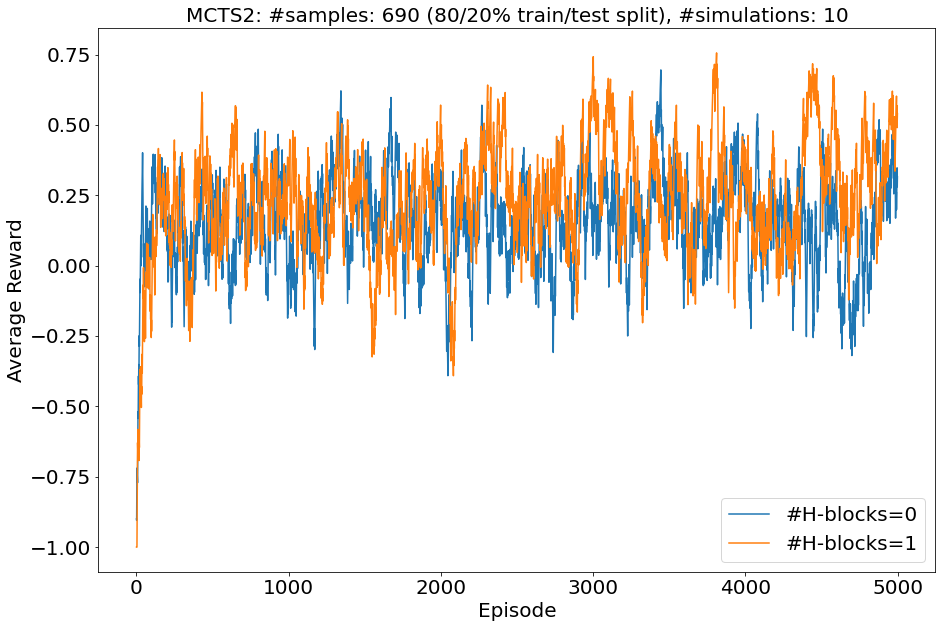

In [6]:
fig = plt.figure(figsize=(15,10))
for (mcts2, n_blocks_H) in zip(mcts2s, [0,1]):
    running_rewards = mcts2.get_running_rewards()
    plt.plot(running_rewards, label='#H-blocks={}'.format(n_blocks_H))
plt.xlabel('Episode',fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel('Average Reward',fontsize=20)
plt.legend(prop={'size': 20})
plt.title('MCTS2: #samples: {} (80/20% train/test split), #simulations: {}'.format(n_samples, n_simuls), size=20)
plt.show()

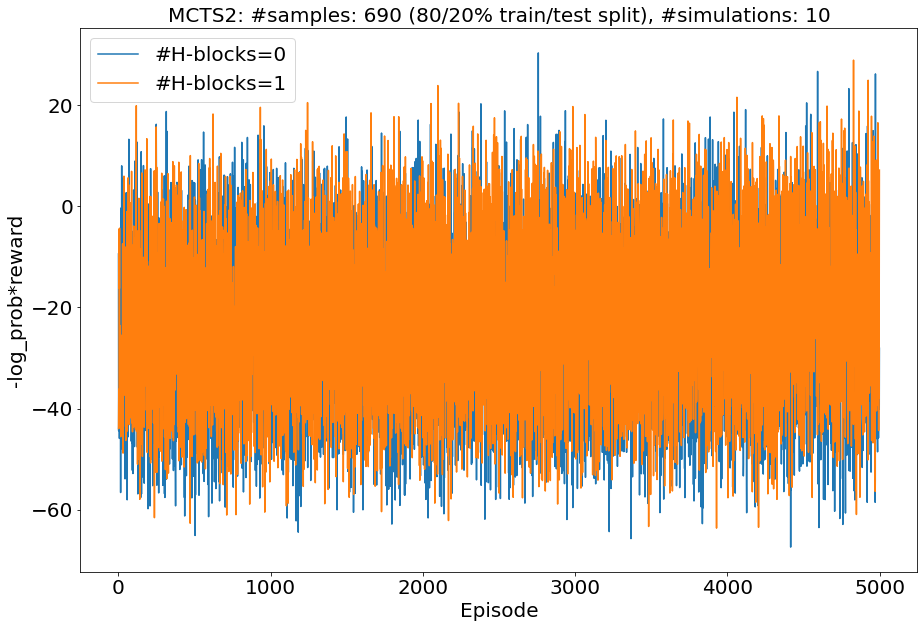

In [7]:
fig = plt.figure(figsize=(15,10))
for (mcts2, n_blocks_H) in zip(mcts2s, [0,1]):
    losses = mcts2.get_losses()
    plt.plot(losses, label='#H-blocks={}'.format(n_blocks_H))
plt.xlabel('Episode',fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel('-log_prob*reward',fontsize=20)
plt.legend(prop={'size': 20})
plt.title('MCTS2: #samples: {} (80/20% train/test split), #simulations: {}'.format(n_samples, n_simuls), size=20)
plt.show()

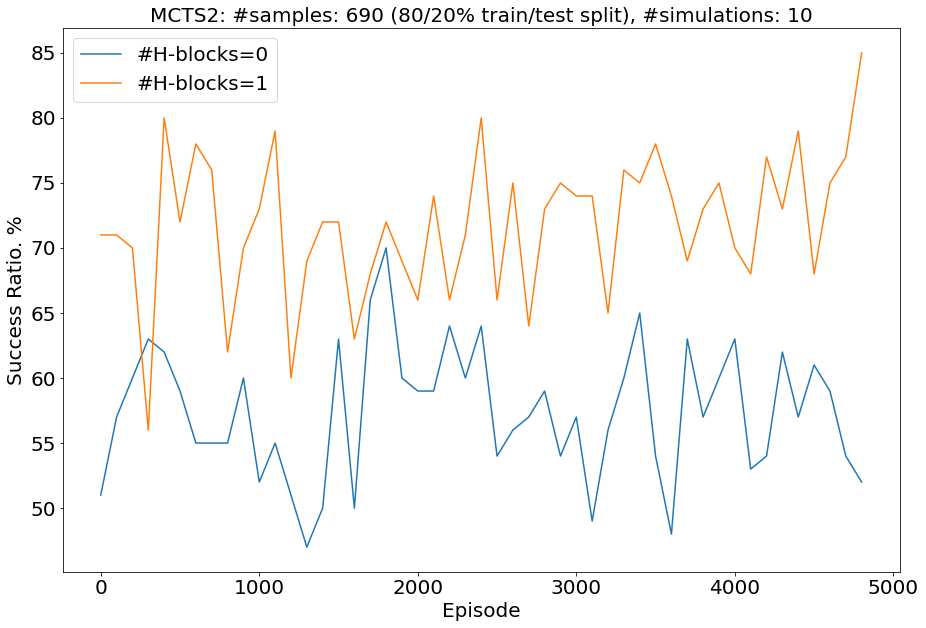

In [10]:
fig = plt.figure(figsize=(15,10))
for (mcts2, n_blocks_H) in zip(mcts2s, [0,1]):
    success = mcts2.get_success_ratios()
    plt.plot(success, label='#H-blocks={}'.format(n_blocks_H))
plt.xlabel('Episode',fontsize=20)
plt.xticks([0,10,20,30,40,50],['0','1000', '2000', '3000', '4000', '5000'],fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel('Success Ratio. %',fontsize=20)
plt.legend(prop={'size': 20})
plt.title('MCTS2: #samples: {} (80/20% train/test split), #simulations: {}'.format(n_samples, n_simuls), size=20)
plt.show()

In [7]:
mcts2.eval()

with torch.no_grad():
    success_ratio = 0
    for eval_num in range(1,n_evals+1):
        env.reset()
        tree = MCTSnetTree(env, embedding_size, device)
        done = False
        while not done:
            if render:
                env.render()
            if meta_control and not internal_control:
                M_probs = M(tree.get_root().get_state())
                M_probs = torch.squeeze(M_probs)
                #M_m = Categorical(M_probs)
                #M_action = M_m.sample()
                #n_simuls = M_action.item()+1
                n_simuls = torch.argmax(M_probs).item()+1
            probs, action_mask = mctsnet(tree, M, n_simuls, gamma, internal_control)
            probs = torch.squeeze(probs)
            action_mask = torch.tensor(action_mask).to(device)
            masked_probs = probs*action_mask 
            if not torch.sum(masked_probs.clone()) > 0:
                masked_probs += action_mask
            masked_probs /= torch.sum(masked_probs)
            print(masked_probs[masked_probs>0])
            m = Categorical(masked_probs)
            #action = m.sample().item()
            action = torch.argmax(masked_probs)
            action_id = action.item()
            block = action_id//(3*n_blocks)
            loc = action_id - block*3*n_blocks
            env_action = np.array([block,loc])
            if meta_control and internal_control:
                n_simuls = M.get_saved_n_simuls()[-1]
            env_state, env_reward, done = env.step(env_action)

            state = torch.unsqueeze(torch.tensor(env_state[:2]), 0).to(device)
            reward = torch.unsqueeze(torch.tensor([env_reward]), 0).to(device)
            for (child_id, child) in tree.get_root().get_children():
                if child_id == action_id:
                    child.set_state(state)
                    child.set_reward(reward)
                    child.set_done(done)
                    child.set_action(torch.reshape(-m.log_prob(action), (1,1)))
                    child.set_action_mask(tree.get_env().get_mask())
                    tree.set_root(child)
                    break
        if env_reward == 1:
            success_ratio += 1
        if render:
            env.render()
    success_ratio *= 100/n_evals
    print("Success ratio: {}%".format(success_ratio))

NameError: name 'env' is not defined